 # Prediction Script
 Contains function that takes image and makes prediction from model.

 ## Imports

In [1]:
from tensorflow.keras.layers import StringLookup
import tensorflow as tf
import numpy as np
import sys


/Users/myrrh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


 ## Load model

In [2]:
def load_model(dotkeras_path: str):
    prediction_model = tf.keras.models.load_model(dotkeras_path)
    return prediction_model


 ## Image preprocess functions

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 1
padding_token = 99
image_width = 128
image_height = 32
max_len = 21

# placeholder variables
characters = []
char_to_num = []
num_to_char = []

charfile = open('./models/characters.txt')
characters = charfile.read()
characters = characters.split(' ')

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize_with_pad(image, h, w)
    # documentation had a different thing with 
    # tf.image.resize, find padding diff, then tf.pad
    # found this function instead and I guess it works fine

    # lines below convert from vertical to horizontal, then flips to correct orientation
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(base64_img, img_size=(image_width, image_height)):
    image = tf.io.decode_image(tf.io.decode_base64(base64_img), channels=1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # cast to float instead of int
    return image

def process_image_labels(base64_img, label):
    # calls above functions, gets preprocessed image and label, returns as dict
    image = preprocess_image(base64_img)
    return {"image": image, "label": label}

def prepare_dataset(base64_imgs, labels):
    # calls all functions above, makes tf dataset with image paths, 
    # maps image paths and labels to tf images and tf labels
    # TODO look up AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((base64_imgs, labels)).map(
        process_image_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


2024-01-14 04:12:47.588727: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-14 04:12:47.588746: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-01-14 04:12:47.588749: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-01-14 04:12:47.588777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-14 04:12:47.588791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 ## Image prediction function(s)

In [4]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


 ## Main function

In [5]:
def predict(img_base64: str, dotkeras_path: str) -> str:
    import matplotlib.pyplot as plt
    img_base64 = img_base64.replace('data:image/png;base64,', '')
    img_base64 = img_base64.replace('+', '-')
    img_base64 = img_base64.replace('/', '_')
    dataset = prepare_dataset([img_base64], ["null"])
    prediction_model = load_model(dotkeras_path)
    for batch in dataset:
        batch_image = batch["image"]
        pred = prediction_model.predict(batch_image)
        pred_text = decode_batch_predictions(pred)
        plt.imshow(batch_image[0], cmap="gray")

    return pred_text



2024-01-14 04:12:48.743858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 633ms/step
['MOVE']


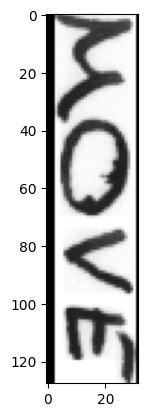

In [6]:
print(
    predict(
        'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANUAAAAwCAAAAACjomBuAAAMz3pUWHR4bWwAAHictVttb+PGEf5+v4LVhwYoInvfX1Jf0rxc0wC9i5E7pEiLoqAt+qyeJBoSXd996W/vLrXLHYqzpOhDgSBRZC5ndnb2mWdedPXNx+2m+E+1P6zr3csFvSCLb75+8eLqdz/8/P27365fFXf1flu8/e3tu1eviy/um+bhq8vLp6eni3W5vXjcrW+qi9v7y//efVhfum9WN5f++eW2aspV2ZQXq2b1hX9d+5bbfVU21erlghHCloQuqVgU99X6/X3zcsGlYIti7f5aur8QQh4XxaY8NMttvVrfrdMyvaR6URw+VE/uG+M/NmXzeHi5uFvvys0i7YVfkH/dOEUWxdN61dy7p4W27n/266baL70kJ8UtrzbVrVNgVR1uq92q3DVfffWHf/zJ/f335UN9+GNUx/3L6Xz87p+Lr18UxdW2vL1f76rlw369cxtbPpT7xv/h9E/LjftYNNVHJ+bb4vXPv74qmtrpXT8Ur/cXxY/lunH72WyKu329LXb11u2kWe/eF+XuU7Gt91Xx1/KmftwXm/VdVVxXbofF+uDesSgup+TdVMW2XFVF2RRlsa2q9r31XXzj6+Lav8gJ2ddPF606r9e392W1Kf5c101xXx6Kh8emWNVPuzOklcW+OtSbx8adQOH+ae6r4vB4829nYbeZlTvto+KFU+umvP1QrYqbT63Uv63d/n/cr+/u1s394UuvmPe9M2S+Lne399XBHWrx6qNTffe+ugjLri5zR3Tlnlt5V2iqHTy39r3lwbnTknrnKg8fnZ/4/356udDc+Y+TsC9vvQsFt7LWfbtKS1ZhycovMZwuirsVcVeLUWb9Z+o80VrhPzK3hvuX3q034I2yfxGW3k03N60AYvzHo4DNjRdAWx9+v6127h60jl9/cN9snCM73cjRx5t9/aGKr9ec84U7GndU9/XGCaLSaXOmey6Kx1YTLrT/eNTk0WuilV0crejs+FTvV6ebWB6vmzuH3W21dNd27wR+qg5OdvneiX7XKdG9x73pdvtQOCnC77yVYtKF1gk/JO1cxZ+7lz+hDA1y37yJcv3WEdGS6IFoxZNooYBosEwFjTXplkkFllF0mfIecyKNm+llWgVpLC2jAF9xJZWN0lQyq03LKJtrVhbM+u7naFaHU0PB2gZ9lUiCoXU4qq9hYZlJRhUEbFPM1ZcHfX/9LurrPR/R2FIbRPNkYaAxM6jGVgY3kLpbpqHjanQZJSKcjLFppyLjdWftVESHv+5umrvfyE4pNTLonA6HUuBNCndCyr05PSqRtFngu2auyrJTOWrcoRGmt+DR1sk7KJdAb4brLVUwtkjXAN4CkllmWJCXlkk5fbbK2/VUTwV8yUHpTEupYKmfOjRr0RoRbuLNAw4JldYZG1kZnMJQ4BSQwvG80pv6ycW323rXONYBXv5Qu7h8xPejVsYf1yX2BCMeSAePXF0i73ZfukA+jOnM36BeTLeMj8f0dkkvplMCgrqgPAZ1I2gK6mIyqNMuqPsD6QV12/LaXFB30IBFdcHESVRX0RXOopRdZPeXqBfZ/cmPuR9tI3tA0R+HQhEv5PboTBY4IeViMl7JEB2tkmkdQBgmM8uOuGS5xHCJ4sFGKhKEcRSCWSamkrA3nkKxY3+TsKDpkWdYAS4Y4BkUB10t2MAkFmip9CwsoYkZ/fDup3iYzm2wkEjCacjEVagAwU3PwzGa6MO3HeJ7b0WDFA37lilAWsggMqDNqBoqTWBkncd5aOIQiUoebxcao0hwKiFQficz8CtEUJunG2OhU+H0g8oQE60CsQby0BM0PWO7YrBdjyLYZrW2g836DU6wPGqIGl4hMh2QTSBNvXUUCFQjMQrfbEdB3ryNuz3C5VA8IyFJsTwBhiWTF58RowauTBm0k8AXsmgnQN85IC58xJUfHx7+byEZfff5JMBFWJUTyQT6zCwawH2Y6NEASjx0jPGAdk2fBzB/lSMPIDTyAGlJ5AHUL5rgASzygDal7vEA2pLCESKApvfCn3qPCOjouV3xZaQmFHkA83lOjwdQysdTfJaIwHev/p6EjuTzjkEmXFJykgCIgN6UEgWu+LMzVpbC3UTGKgO2uMADShAgbkgclGIdoLVeRyPkebwZ15h1Rl50ZT4sx2YkagzzOP5sOGQwXe7A3/sSmi/HkxIJDTWkTxa1l7U82gvUJMjzU1+WIlbKjsoGi1fMdGcMEliI4PMIDUvxI5W3SpwWSOQ+iGeHaZZSwhSmw13H5Esh4s6B1WHMVZmYq2VnsznkmrYlp3YdyIIheWQ5ckA76DAodMz3at35R4cB9R1mJssR+IE0TM8rQDnZ5nzyyIhlQTwD7FFPYhCjvFuYkgumIDMa8a+zqcKzAvdzyQILbsCoyMnkVGDPzKsZ6NM+gIMJMVE00KeNAMol78iC8jlZSxY4MTyQBTXJFHhkCoyyU6bAfdbSZwrVfg+ogsKpAsnVDM7oDEWm0J5+nylwMl4y4IkpvLl+9xYKxcgCD4GM2eS9EsIyDhXCRBexAFTVGSH7mIlTDgJnr8w8D4w56Db8kkjG0bZY4I7BgFlAciDECTzbM8pGxRlqKI4nEpbJuC5hOCyc5mJ1MpRE8YjlqttExIWJHLQg1Wk6r2zBEyu6iBbGa9sySj6j1nuWXD7W1ZoutrN4ZsyCpBUemsoEwu5acGHRrWSq9MLqKBHUElgmTz3LBqm30O32CBYo19BkKL+X3udqGaF07eAFJMoErMx0x6gm0VQMkA026eBUi85RQY2fTt4oqpORk64MNgfmMQWOdUM8EqM0pYt7wKeMzGRJPX7Do4VBH5FNG9jqDgnSdg1INTL5HCOqO9N0Mr2C2OwLGYnvX37tclAfrTBapO1QOAT6bOGFIf5k+XnwNU2nPofafC6d4qdEH1A4prBn5tVePOD36ZTw3bfR2otf06dT0jOVQKf4seDiay/aO3bowehpRiW62gs7HaygkvGx2gvFay8+b8RrL3GMphgZkkm1F3bKqIQVo4xKwCbMGyB0pPviXsrxNCLDpyI6CA3aL/T5oCYSMfqlA7V21mgoXMV6gjAsA/44xGgm4m4Te9SQFOHhJo4ouHWgcAOhf97MiQDdjdFigAlDGY4EALprMsHqLMHDDkXyQSyAEMqjCsnYcN4m0/uiRHSuleKlsRnqDHlZXCgBFPeoa4YFsVhJFEahUJxtBFkbvRk/X5mJdTwm08LIObyLh05d71ztmeV6/FyHhS38PGWMV1C0Np8jOhW2ui6hQzJMuFLRJzRoUwBDi0yWoLGjpb2a6+wrOKyKRezFWE2sa/QAr8fNMwSBSD50ZwNHPHDQcXwoopUGRVuwkOIXiLWFw+PNIyjnkyNl0/MpyXPowTMpCY+VYHk6k4LI7D8zcyrklJEoMcFI2GAoRPPUDJJGdEMhNtZ3OJvmIzINetJTPqL9ZR+r8DCMkEhxOuvZVXimB3IDHaGcnLIR5ej+2EWTiY18/z0QiJGRyMEVgOH+YBGOpyLGZwVa27DBIMgscJCJjFxf82+71AHDNCWCayo4IsdypaWzhKeuznjrzNAApwo0VnrpM45JJhZ5FJhghFg2k1bIRCsmWmdxdNKdFMezShzTrFRD14ATODNbZzIFzInWGSVhbNOpDDiYmiYHNOZlCuC3yWXQZ+ksh7z+eFfxchId2lrwSVsfaypHxUGlg2fcAy5UZngPIeUTmYVC6niJDH7z51+i4RzkDTa55HTtlAaFDjNtpq6p6iEQa1vNTIFk6j5N1wpN7KEoASpncFIkN+FqdXALTRgOGrg/d7Mp7pDSRVD0PFqB77freHUpXxtsME4Ti0PKAA+BdWl8u4zqTmswdj1Z/2I0Vu16bgGnykZmmCdJ1GcRmueSqFiY06cJFJDJBfbMHBI1KOq00WaEQg0qOpZyUNFR3U9lpEjTNNMMSgUG5SNOnz8ZD0kjszR4g4yd1nNsN4k++LFSgf8UKZR07CmHMnJ8mkbBHtlAKsakVHAvI5LzCjsZs0QYPKUmEzIYTigEj+vguJ2dTFVExF7DNIq9Cs8HJSVxXUIDCUddM3O8Me82DO+T4NuTJpoTjPNR+OsYOa8NqBLB/DKe55dY+y+2qIwGqAeT9XkhRiVuCUNMcY2RSx3PBkzfwDmUzAyjFTbaWKIkQM2jPSqRS/CThhodqaURvuD5wmFynSkd0TjuYyQ44Z6l5wU3hXbCOlTAlOfhtzbUgNl0+PMymWVP0eKAdsG6V+YHSTSOtTuYSAtZry0+rxiksNZUBEC8PRU1ACNxMqdAj8UIBKlyKQxkMZG1GTBsxAisvWVWMh7NDJqsfRSYl4SoRFJHO9VMxB65sQKnbCOCp7nI5/AC5O2JF1xdDn9ce9X+MPzrFy/+By2P0k1iqzLvAAAaFUlEQVR42tV695dUZbY2/8e90F3h1Kmcc1dVd1VXB+hAGIKCgsoMIqKOOWIzDoqjOGNGZxx1FMRBSYIKKNkmNEmkoXOornjq1Mm5+ofv26e6qwnXu+5a9/vuWnPPWt1Q1Se8z7v3fvbzvO+Z9X/+lx5lURB5Ijt69buPP/x6/5Gfzo7m8oVcCeMEXirP+t+KShDl0sjBVx59sC0UjDXP7Vjy0usffPTZvjMjKazEzJqcnBTSezbvHR6nRbk8WT1u/O/WT+Wpc8rVb/6fRjb5nx7lsqLQ/bu2LGzdWfr1a3mB7Xur02Nzms0Wq9nu9rhcnmAgdu+Glz7tHgBUSu+7dy+45+nNfUxZFif/i0OZVMpVnMr/B1QweulXYXHU8Ea3FUVbu/+TWOFX/5w0OyxwCmK2mCw2m9lkdbq8bn+kY/2sssJ83N7cnmxZ+HmeV26Kwi1Yqt+W1RPKMxNa/bMsSYpQGLp2cdd7Xc+sW7Puwaeeevz9Y8cPnR1J5/EiLYhlofwrEYYvRIbl4e5y5Wt55oGiRA99HNAhqN629ddRYRc2dVgQE2o0WhHUYjZbbTar3eF02l1Od+Osspx7qbO9ozmefKaXgZmrPLl8c9rBNzIkZ1n5j2ilykAVnqPpUvrkq2vuC1hNBoMRHmJE3Q3J2IKut3ee6sUIkqHhxsrM1MygYtLdP9OcVK5kSbmaDvCRKu5JWuBWto4Tv46q59mlHkQPB2owGGweqxm12l0um9licc//y6xJtrBrYXN7U7Kx8zAhCtV0qAxh6hccxIV+glVurrEqZJmHODBUpv+HzXe5TQa9QavXabV6TW0NokEMOrPD1/LwsZ7BPCOJlRkrV2I9PTKFHt5+36MHMA7SUL4RefX21JkOA4IajLE9RJX0KtWGHXnh2W5WZkf++psookf0RrPJ4g0EnZ6Iy26z2ywWZ926A+lZkxzWvSDRUN/U2PJqnuWBDaSZUYuSJMA8cviJJ7qGWVmR1RGVb8lRiWcYtjh48KkmM4poNXpEZzDoNHptbU3t7FqNXq9DjNbOFe8eH8J5SYGbKyquKqrC3vdWtrbf/xMhAOLJqSRRVDqS5eyndj1iQF1vjfM3FSE3vnfd3MUfF6jihUc67TqD1T93xSMb3/38tQc3fbVh9ZL758di8Ucv5JlZUpk4vQQ+JFtaf9+L0yIjSmI1xQUecIn02Q9fXrbsG0auBK98c6zUWmdY/OeuBXaDXj9njlan0yEmnQ4Awsd/r9FqdQjgRByL3r5QYlmGF3nlJlQ/r1m4IBlNbJ2glZtzHp5B9t2r05lN5hWXSlw1sJOKMPbuonkNia7+Ita9ZpEPdTy28+zPfUPjEwMD17Ijv1zuPfPNgZ1nM6Q4S6Dp83fE6uLJ+oaWv0/ghCxWC6ssSwrwQOnMA0vaE02vZTkVkXQzs5cVUZYY7MrzXocJ0ek0tbUajRY1ABbtHA2imw2fdageAlerc62/mMYIlpPVYFdRbW9r7WwJhtZcYWTxZvYts9iJGETZEtydocQZVDKxf9nc5njdwlNYtvux+5548rXLKQzHS8VCjiDU2iULuTxBs9CFy7LQ/0wiHG2AJFzTWyxxopomahSm0PFXn2/raI0mVvXQcpUFb3q+QKUPPRe2GY1GrUarNdjNTffctcKqrZ2tMSA1tbU1OqNBp9dADO2PHUuXOAnmQVaqqDZ3/GZ+YyTU9hnNCGoNK9OhEqixT8w1EKy6E0VOmj5ZlGRsR3MikUwsvkhNfPrcm2evpXCmxHAshpcoiqNoQeI5oawy2yzIoczf5vp94daWhrZ9WUYlpHJ5OhoQrvzutkRjWyLe2c1IkqzAVTex/KRCpPYvtZttqDmcdLmXvfT51u/Pndo3H9iiVqtRUc3RaBFEq9PUII4nzo1hjJrSkjI90G+WdjYnG+LNjw3D/ELSAxtAWYuQgNe6kFq4svMyKcnTJ0uTSv7DkM8Xiq2+RmF73ruczcHdaFJWGLrEMgzB87yspgKk0yxZYLADC4K+YEM8EtvYh0P7qHBrZeiySGV2ttTHmqL1i44QIi8qN6hELX1ZwH+YbzGYLKamtw7s2HFhZHR4eGTg0ouIzp70ojUqMGAOLYRRo9e5H9o2QkFM4KnTA728PhlviEfjCw7DlKt3VhSIZZkXsic7VaKx/3mEVaoZKJWl8Xd8NosttPo6SWfHMZLgZR5EnwyTrfC30P6sSZEuHG+NtYbDwXD0juNpiKGk9iBZJQdZZMb/3hirj4UiC4+WeBEuv1HUsiSKVP8jVpMRtcbfHRoeTRfH0/nCRHrs6Lqml37cvs6mrQFgetSK6GqAhFHjvO0jJVCfMxmY/WxuKFIXiTZuHipyMvBphWHLDDGy1aXR6o2dPQVGrrKFwLGpDzx21OBcN4yzNMnwvMBDukHpwzXKragkns193xoNe6LBQLT+3XFOktX8BrWg8rbA5b6qj8YS0WhyL8aKN7M6IFSE7HeNNtRgadk5lMvjJYYgiiTDlvK9JwbGrnevQms02lr7ExuWW7U6fa1eiy7+eBDjOLE6BOzSc8m58Wgwcsd5AtqZWsmyyPOl3PWHUR2it28cJTihejLLUuOvWk2A6sXRLEYxHM9COYIchJ4N1HwrKp4lxr5qicSC/lBdOLR+mODVqi2rzUnmRJJI7YiCskpEGrYW2IrCmJEckiwVe9Z6bSaDa30fhpMsQwmKBAGl8XwWL+YyJ18wao1G79eXj/zRB+QI5YWGtg4SNF1NKmJ0d3OysT5SN+9HjOV4yA+lLNI8VzrTiKIGNHogR9Az6cow1MifjCa9zvzmSAa4juIkjoVgcQIHtH0bKlGkx3bGQ40Rt7/e51/1s9oRp7hCFECjcYVDTW5fJOKNvTxKs1xZmtFNZVHh87saXA6TbdlxoAGWpSUZxqVIRKlEcyJDThzrcK5fHNg1OHRuswUg6ZAaJPptluWqqITSUeChSF1d68eDIBY5AaSNzNI0ttum0WnNK6/kaGlmvDhV7F2PIoje/NG1sdRENlss0jQjCjRLMv8hVgpPYYfjgVDE5Q+565q/ztMq1VWkjSTBc/DTzU6Px++vX9lDcIqqUqd0FHA0x6Q2BpwuV/itCU4SGE4GJQI/AgeZIbEMS/VvffzUl/f9lC2MH7zPpQfdAQT/ch9GMtVYpU/Oh6oNh2Jdo2qfUWBOZI4p9j6ur9Hrna8MFVlOqTI7S2a6FxoQHep84rujBw/1/Hxt4PpoHiNphgRWlW5FJdBkdn+DP9rgCgV84cbnhwmaE+As0DeTAk0w2KkWBwgtt7/pcB46HaSgJKiyR4C8Zgce8ALgtiNFjlUEUYJ8AFACpwhAMzzI7r+8NTFwYgzPZa+detgMIwLOCL/Rn6OnH07jV1a3RqJ+f2Tp+QLFiCpBSRyd3VsHDQ5tOJGHsM7wAImPbncYDVqj29s5P5FY8eKjrz739slhyHUomttjJbFU+kAyGIu6PJGot75jf55U9Z5KdIoI01785XdOVzDqsdf9dRyj1evLylQWihzV/7THGwo9P0qpTxcgy2G2ATYwPiQTj/d2bUnTDEXl8qmBH1Z4QYKDII3sn6gKVpHo2zQvFAsEQvHvc5QgiIrMQ3WOvGLTI1rH3/pLIhB3dbzFiXNPGhBtDWI0mc0GI2q0uVyhO1/fceg8cIp0GwfKfGng3Xpfnd/pCgUD4cTveyk1VrykMiCwaeHib70WV53X5Fx1sTSlpuQp6QFXnlkWCITDG1MFTu2gfLmiSGBKFBGaAosP/fWtHCtzNFUqZIcOPWg3oOAdjIvPF6p1RRe+X56MBD3++K4UwTGcKCgMhfU/jUJQA8cLDMlI5WoR5q+879PX1vx7DWpEDGp5oWaTyeLwN96/YyTP3paBMOPDL4eCSa8/FE6GfOHknjzJSmBJoMlK8MfM8QVuq8XvdVii/wBNL04ZMGgSEMj0h3F/OBh9DehaVAUPREkBsoHWAK1MEHl8fBimkaepfL6YH9y1BJwQqq+xvDlSjZVAXni9PRzwesO/H8DIEs2yIp0f/nElFKBxxVWcgtyY6a+pXS163Zx/mz27FoQ0YtDroAEawauYHW1/O0Hd1oUZsnT5/kBDPNYQ9CbCvmC4qx8naRnalijwLIUNfRa2mVGHx231P3OdYjlV2kBIABZTGnm/PhDxNewex2keeEKRQLzK0Oo5XgCBDWTDswKAZymqlMcmrnwZNYD01esXVI2gGs4vEsGALxJuPZrGaY5hGXzs+EqTHkHqd4xgtOqMqtRyfpFBV1FhtVq1teu1BkBlNJrsTmf7m9RtGUgVU4cWBurq64JuZygUCkTb94IKhQEygsCQWLbnHofNjFh8TrO1cU+RIIHcwXNBGsoicXUtJI8nuPE6BhSrRrEiEuFPgqIChxxVjRNoGpZgBHL8+O9Mllq9vsb24vTDOYZKfzs3Vheo8wS3TpAkQZQKmXMbzHojanu4D2egd8Dl0yefjqMVW4DajBArRK/RGxCTyei0WZ1PXBFuYwuaGNuT8IbCAMjjDfj94fDvTkOmEQQNeqiQG9kRs7vMejNIFdTx9FC+QEBbguFLgsyRfet9Hq/T/0Q/BrUIAqYijKfNH/A/cKIMDho6hCgyePbKCy4jeC9drXlVNVYkg1+6Mxaq97v8Dw0US/kilu/7gw1cO9J5JF2AEYCOqsqrX+6wIuCutWZvPDEvZrZYUbMFDL3dbE9+U2DlW1GxdP5gRzCciNVHQ75gyB8KRt8ZJ4kigZeIUjF3bo3X67EZLC67EUGb94xi0Ff4iqKSWfLaXc6gz+lfejmvNnlQZWrR3Vh+U6UMz4J1knkCz517NYBAXSHglJdXmZ2iqOHnwuGIy+1uP5Yp4gSeOhBGtIje8d4IzrDAiuUZVEOf+jUIqjW0v77/+6Nfvbxpw3womo51T6/bdGiC5G/nQLZwZmU0Eo/H5wUDERCDAf9dp9NYkSiW8Hz61KMN/oDHDa7UAm3dvvZKAfwMDba4DJqk1Pdblzvg9yUPZRggD7lSb4AXkE2ZM0VlHImXWI6ixp6x6XVGk0FdA2irNlaGoXPft/h9bpcz8M5IgcAnflwOEgRxrDmTI0ioa+EGqpF9Dk2tTuP96Nz1oUx2sPfq2f0Ht526PDAykWegOd7WhZmJbc3xWDRx16er6/z+kD/o8z92JJXFsGzm+p67vd5AqPF+lxFQwYACHw+B8+OgRUNPokvDTwdcoZC/YX8aZKY4tXxT0R6S6pXU1FNFPvQu0IaXklqtHkUra0KNN2R4KX/2Dq/L7XDY1lwcxfJn77eYTHrTA+cyJRYOkGCT1fGObDfWaGp0i44NjeeyhWw2m8/kUplsIQ/kBsx0KyqOSr0eb2yo6+g6e3C5x1XnD3rdwae6+4f7rh3vanH7AoG6tfs2BFC9DjXoTPMPpcF1CrIilVVn8E4w6Pe6Qy/0l2ihstYyLerLU6YTIKnLL7JKpj/P16uLRqhJqzNvmn449DSycOVhj81hsZjiX/elRre51fkL/ZAtMowoT91t+uTBzVpwa8a1F0ezOXDyWYKhwI9QRYZlwS/ehoonBl+uT9RHF24f6N1a7/YBqTms9cv/sOPr7Xf7bA6fr+7xk8PdD6Awz6B5nGvP5ykaTI3EA8vnd8dhDtz25jOgicsq2VWWB4H1p8SipEzRhyIIbPrzOy06g8FkqtUuO1tdimBpAhvYGrJajTazbV3PcM9v7WazzbqmP49BUlXE6Ayq3kd0tZpaU9fARI7CsQLwFkHheJEENcILM4K5iqpw9bfRaChxR8/4+JkHgz67C8rIZve1z613uax2d2jV6Wyh7yMXghrNJp3ZsyUFgg0mnwEpVDzZ4QZ1awt9kqHAgbCQcaAFBLUY1FRUaGHKskDjYkqjxxeYjWYUqbFurXZhnqShzZ/qsFstdhsa3np6iw8Eg2f9yXQRGp08vUoyffKl1Qattsb49kAqgwGsIl4sAKXlKQJKBSNu68JC4dJ9sXA4sebiBDb27Vyf3RH0Ot12c8hnN1osjvpNpzNFLNN9j0GHWi2IFk3uzZUYEcJO0iw9+Jzb6fW4PQ+eHM2xoNKnKqqyDqWyofqf8qQEHMjQVGHgoyikoKY20j1RZQuwiNDnt0Qcdsg7y9IP2u1mqyl8cDxPMIo0vfpdRfVTiwE8qO2TwfHxbLGE5Qt4Lp+fGB8ZvNr9yWffj9+GKndgQXNbffKp/gyW7d3odlg9bpcr4Ap7LGaHf+G71/MkV8wMf+HX6k1m4CfbQ1fAsTGgZ2mWyvw4H1q7zeJdu/PqGEZwYJIEQV2nlMvV9d9JVcbzLEeTmcsvInqd1rDicmqmrsD44Zmza52g6MwmW8wDZIsmz2EcRF7kK8tZM8tse/1An5rgV72Dw5ns+MhIemy0/+JPB/++cfVKl6fu89s0e+Fvifp447xHR4lidvjH3/hdbqvD7rS7XTZHx1tHJgo4QWL5fO+zBpXDEAR4sD+Ll8Cxgl3Lj2xLWm1Wq81Z/9D23onK1yoqWawshFWkrgBmlRdoEIPXn0W1ep37swGsyoHqAj1dSn3mN5jMULgWp9lgDr82hjOcqrS4qaqcPvk1ow56cGhb99lLv1z/5bs//v29V7sevidiVzd6zOY1t8Uq+2FTY7yx7eWhCYxI9++/G3LQaXPY7HZH8z8Hs9AYi1myODZxoA6B56J6g3XRl/0TBA/9iuRorO9Vnw0usJrt0Wf29hbwIgsyA5qUmoYyJ6qrOjxLUwROFNNXHzVAL4qfylAzsQLLwtLZ7jYDKDr1x2gJPnIlT/OgrkV1lUW+gWq90WCxak1t965as+6R+5YYPVaLzWbU1ur00ATRhbeiIgbfqE/GGzv2pTCSpcCVP9Loc9msFocr/sfrwDNksUSwTAkffNsHfIFodKjljv3DYK5ZTgBtUOhZH4BiNzuNqCO58VqqWMqVcBJUAQh4nuZUcUHTOIkXcpnhkys0WjS8+XqOnNHskJwcWbj6qBExmY0GxIA6N/TkKZChogK9bmoFfPrklYjBZKzVg0AGmYggWo0WlIZGV6OBmTIYWm5FVehe21Qfb727J0NBmtDF9JVvXmqOxaLLXthxPVuCaaZoNddo/NoGG+h+BCQm2rl3OFvM8zxkTyHV8zgITL/PDuFq+uBINwDL5wkCZwWQVCQB7EcxxfREdvyXfZt9em1wS2+mMIMKkhXCxYx+4tIhRlSrNZhi+9KEmn5SZWNJLdEqqtZajU6nVfd2dFpdbc0cdf1qduUfxB5btvNWVGPvtSeTifaNQyRJsixdAsIc/P6fX++9MD6ew0lRmRQphmEomsr03G/SIRajXqu1dO68OJYtFks0hRXS397ZAszscdgtVve85ntf/uKbs9eHx8YyEKB8KoPjeWz02I7dB15Z6jOb7KvOQ35xNxaZwQCIXL5nMSQRotXpkfgPE4wA308vY7E3NHu4RqtDdFrw/mBGambPnlMDv2tqwJqYuw5fyd+Kavz5psS81o7n0xAWEN4cz6vr1lAHJYqFT2Ve4miGYSm8kP7pARCXJhMCfq3huW/6hoYzcE0pmzq7LWY0We0um6oLTPZQ86LHX/3Dnw8fP3bowCdbv9z7xeH3757buaA54XQHln45ijEzK2dQV2A2WIlJq9YLgUEb5/UUwKxVVjCmWp1YVeN31tRo9JpaLZiR2XMgSpB6wMpqMs49nprZOZlG1f9QQ7yldf6mFAkClechJXigAQ7Cxqurf0qJA5cEMpQiCpmjy+w6LWo01GoRc/KVf3xxbihHlUgK63vnbifAtZisVmi0FrsTerO/fcn8pkRdtGnuvOXJREM0EZ9Xd9crh+H54syGAIgpXhZYkSOG/uRQN0Md4XdSRaqyRjwlvVQ+nT75r8jsORrIOigtHQzA6Uy0PvnmaxueeuDh3aN55rYufO6OhngiOf+jLAmRB6sL0welLvKSGqgyRI6Ry+oChsAWsJEjbWCsEZByCGoJBKPL3zimSmuWHP1mpcdiAgaDJmcBarLbHKBX4VegLhSJ1gUCDRHoHvcenijmaIEXhJmNtjJMYmXh5tRCq8lS99LHAyVGAOqTJyt1pe4GVDlwl0uj0dldsZYXHl7V2rTmn9u/PfzzwFD/cCo1ViSY2xTTobZoPN5413GME9TniapVl9RWA4fAgx0FVyFzKjKGzA28aNPBvaEAgDOMKmOlMVqgmHzqp83L6/1eh9WEWq1Wl8dqAw1ktdqD8RigigSb4o2L7zmQLpGMrJL2zKao6j/BG/LcyBaXNfLGtTGgLG5KVKgbWuJNTqTv/cUt7Vs++e7otatXzp25NDSezWTSmTyoW0aUeOFWVJ+3hOvjbZvH2Irjm9rpU2XpjPBWv5EgF8BYFXIXupz6Wi3AUvdv9Ij9uQxB8QyDY9mJq8e2d218NmEzGy02aHhWM4TM7w7E65d1zF+xZt0bh0/nSZoSy2Wa42YysNKoRZFncle2PL6pH1OF840dx6ni+m+88jCrqylc17H6BC5U9uOl8tSO9FReK9XlZ0U17AJHktnzW6IGvVav7tzoTW1P/likWZA9dAkjCSwz0Ht135PJiM+htmWz3ekPBSLxBZ/uOnK259oEVoJ6Vdf8RFH5n35xZtYTnS31qw8XIdSqIBBpyGjVV1dmSqrAUmZ2Czgin+ndttSN6tUtKTS4bTDDcBz0FmBLkiJLLFlKDxzd/f6La363pKNlyZKuP/3hma1f/jKUKxSIyqquuiuhasT/cVTrO9p+82aahhYhSupDlcreVWWlqPL6yE3vIkgcVSxmxs58uswN0tpif2oIZ/41X3KatW7R4r+MgasQZGm6lso3vUVSnnk3RoHMgWTjea6UuvT1n9566Y0PLuMU9y+Kavezbw9wkqzuV03VqVh96WCqxJRp91YW1S0LYELgwmI+k55Igw2VlH9NVP8XMNtFL9MnYHAAAAAASUVORK5CYII=', 
        './models/50_epochs.keras'
        )
    )


In [ ]:
if __name__ == "__main__":
    arg1 = sys.argv[1]
    arg2 = sys.argv[2]
    arg3 = sys.argv[3]

    charfile = open(arg3, 'r')
    characters = charfile.read()
    characters = characters.split(' ')

    # Mapping characters to integers.
    char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

    print(predict(arg1, arg2))
